# Working with the usbmd data format
In this tutorial notebook we will show how to load a usbmd data file and how to access the data stored in it.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
from usbmd.visualize import set_mpl_style
from usbmd import File, init_device, Config
from usbmd.ops import Pipeline

## Loading a usbmd data file
The USBMD data format works with HDF5 files. We can open a USBMD data file using the `h5py` package and have a look at the contents using the print_hdf5_attrs function. You can see that every dataset element contains a corresponding description and unit.

> *Tip:*
> You can also use the [HDFView](https://www.hdfgroup.org/downloads/hdfview/) tool to view the contents of the USBMD data file without having to run any code.

## Loading a usbmd data file
The USBMD data format works with HDF5 files. We can open a USBMD data file using the `h5py` package and have a look at the contents using the print_hdf5_attrs function. You can see that every dataset element contains a corresponding description and unit.

> *Tip:*
> You can also use the [HDFView](https://www.hdfgroup.org/downloads/hdfview/) tool to view the contents of the USBMD data file without having to run any code.

In [3]:
# this can also be a local path to an hdf5 file
file_path = "hf://usbmd/picmus/database/experiments/contrast_speckle/contrast_speckle_expe_dataset_iq/contrast_speckle_expe_dataset_iq.hdf5"

file = File(file_path)
file.summary()

contrast_speckle_expe_dataset_iq.hdf5/
    ├── description: PICMUS dataset converted to USBMD format
    ├── probe: verasonics_l11_4v
    ├── data/
    │   ├── description: This group contains the data.
    │   └── raw_data/
    │       ├── /data/raw_data (shape=(1, 75, 832, 128, 2))
    │       │   ├── description: The raw_data of shape (n_frames, n_tx, n_el, n_ax, n_ch).
    │       │   ├── unit: unitless
    └── scan/
        ├── description: This group contains the scan parameters.
        ├── azimuth_angles/
        │   ├── /scan/azimuth_angles (shape=(75))
        │   │   ├── description: The azimuthal angles of the transmit beams in radians of shape (n_tx,).
        │   │   ├── unit: rad
        ├── center_frequency/
        │   ├── /scan/center_frequency (shape=())
        │   │   ├── description: The center frequency in Hz.
        │   │   ├── unit: Hz
        ├── focus_distances/
        │   ├── /scan/focus_distances (shape=(75))
        │   │   ├── description: The transmit 

## Processing the data

In [4]:
# we'll work on the gpu if available
init_device("auto:1")

-------------------GPU settings-------------------
     memory
GPU        
0     10850
1      2404
2      2406
3     10852
4     10852
5     10852
6      1026
7      1048
Selecting 1 GPU based on available memory.
Selected GPU 3 with Free Memory: 10852.00 MiB
Hiding GPUs [0, 1, 2, 4, 5, 6, 7] from the system.
--------------------------------------------------


'gpu:3'

In [5]:
selected_frames = [0]
data = file.load_data("raw_data", indices=selected_frames)
scan = file.scan()
probe = file.probe()

## Beamforming the data
Now we would like to beamform the data to generate an image. For this we initialize a `Pipeline` object and load a default configuration using `Pipeline.from_default()`. This loads a standard raw_data to image (B-mode) pipeline. To run the pipeline, we first prepare the parameters from the probe, scan and config respecitvely using the `Pipeline.prepare()` method. This will convert all the parameters to tensors and move them to the GPU if available. Finally, we can just pass all the data and parameters through the pipeline.

In [6]:
pipeline = Pipeline.from_default(with_batch_dim=True, num_patches=200, pfield=False)

params = pipeline.prepare_parameters(probe=probe, scan=scan)

# data = keras.ops.take(data, scan.selected_transmits, axis=1)
images = pipeline(data=data, **params)["data"]

I0000 00:00:1748247459.941524  835095 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Plotting the result

Text(0, 0.5, 'Depth [m]')

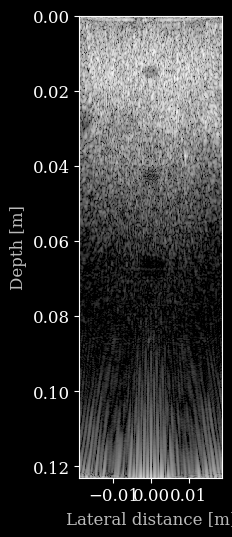

In [7]:
# Plot the image
set_mpl_style()
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(
    images[0],
    cmap='gray',
    extent=[params["xlims"][0], params["xlims"][1], params["zlims"][1], params["zlims"][0]],
    vmin=-50, vmax=0,
)

# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')

## Config
It can also be useful to load manual configuration parameters. This allows you to load custom pipeline or overwrite scan parameters.

In [8]:
# config = Config.from_hf("hf://usbmd/configs/config_picmus_rf.yaml")
config = Config.load_from_yaml("../../../configs/config_picmus_rf.yaml")

In [ ]:
# we use config here to overwrite some of the scan parameters
scan = file.scan(**config.scan)

# instead of default pipeline, we can use a custom pipeline from the config
pipeline = pipeline.from_config(config.pipeline)
parameters = pipeline.prepare_parameters(probe=probe, scan=scan)

images = pipeline(data=data, **parameters)["data"]

usbmd: Loading cached result for compute_pfield.


Text(0, 0.5, 'Depth [m]')

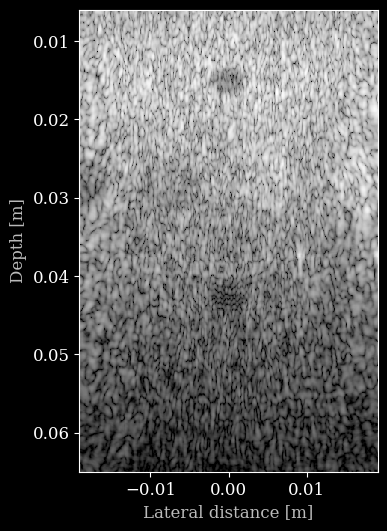

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
# we use the dynamic range from the config for plot settings
vmin, vmax = config.data.dynamic_range
ax.imshow(
    images[0],
    cmap='gray',
    extent=[parameters["xlims"][0], parameters["xlims"][1], parameters["zlims"][1], parameters["zlims"][0]],
    vmin=vmin, vmax=vmax,
)
# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')